# Analyzing the Chinook database in SQLite

[Chinook](https://github.com/lerocha/chinook-database) is a sample database available for most popular relational databases, including SQLite.
It is used for demos and testing ORM tools targeting single and multiple database servers.

The database contains 11 tables with information about a fictional digital music shop.
This includes information about the artists, songs, and albums from the shop, as well as information on its employees, customers, and the customers purchases.

This notebook analyzes the stock Chinook database with respect to following metrics:

* Sales by country
    * Total sales
    * Total customers
    * Average order amount
    * Average customer value
* Employee performance
* US market
    * Bestselling genre

In [ ]:
%pip install jupysql seaborn

In [2]:
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql sqlite:///../data/chinook.db

Set up the default plot style:

In [3]:
import matplotlib.pyplot as plt  # import is done here, used for subplots later on
import seaborn as sns

sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
sns.set_palette("dark")

## Explore the database


Here is a schema diagram for the Chinook database:

!["Chinook Database Schema Diagram"](../data/chinook-er-diagram.png)

List all tables:

In [4]:
%sqlcmd tables

Name
Album
Artist
Customer
Employee
Genre
Invoice
InvoiceLine
MediaType
Playlist
PlaylistTrack


Describe the columns of table `Invoice`:

In [5]:
%sqlcmd columns -t Invoice

name,type,nullable,default,primary_key
InvoiceId,INTEGER,False,None,1
CustomerId,INTEGER,False,None,0
InvoiceDate,DATETIME,False,None,0
BillingAddress,NVARCHAR(70),True,None,0
BillingCity,NVARCHAR(40),True,None,0
BillingState,NVARCHAR(40),True,None,0
BillingCountry,NVARCHAR(40),True,None,0
BillingPostalCode,NVARCHAR(10),True,None,0
Total,"NUMERIC(10, 2)",False,None,0


Describe the columns of table `Customer`:

In [6]:
%sqlcmd columns -t Customer

name,type,nullable,default,primary_key
CustomerId,INTEGER,False,None,1
FirstName,NVARCHAR(40),False,None,0
LastName,NVARCHAR(20),False,None,0
Company,NVARCHAR(80),True,None,0
Address,NVARCHAR(70),True,None,0
City,NVARCHAR(40),True,None,0
State,NVARCHAR(40),True,None,0
Country,NVARCHAR(40),True,None,0
PostalCode,NVARCHAR(10),True,None,0
Phone,NVARCHAR(24),True,None,0


How many records do the most important tables contain:

In [7]:
%%sql

select

    (select count(*) from Customer) as "customers",
    (select count(*) from Invoice) as "invoices",
    (select count(*) from Employee) as "employees",
    (select count(*) from Track) as "tracks",
    (select count(*) from Album) as "albums",
    (select count(*) from Artist) as "artists"

,customers,invoices,employees,tracks,albums,artists
0,59,412,8,3503,347,275


## Data analysis

### Sales by country

In [8]:
%%sql

select distinct

    Country as country,
    sum(Total) as total_sales,
    count(1) as n_orders,
    count(distinct CustomerId) as n_customers,
    round(sum(Total) / count(1), 2) as avg_order_value,
    round(sum(Total) / count(distinct CustomerId), 2) as avg_customer_value

from Invoice i
    join Customer c using(CustomerId)

group by 1
order by total_sales desc

,country,total_sales,n_orders,n_customers,avg_order_value,avg_customer_value
0,USA,523.06,91,13,5.75,40.24
1,Canada,303.96,56,8,5.43,37.99
2,France,195.10,35,5,5.57,39.02
3,Brazil,190.10,35,5,5.43,38.02
4,Germany,156.48,28,4,5.59,39.12
5,United Kingdom,112.86,21,3,5.37,37.62
6,Czech Republic,90.24,14,2,6.45,45.12
7,Portugal,77.24,14,2,5.52,38.62
8,India,75.26,13,2,5.79,37.63
9,Chile,46.62,7,1,6.66,46.62


Combine all countries with only one customer into a virtual country `Other`:

(Store the query result -- a pandas dataframe -- in the variable `df` instead of printing it out)

In [9]:
%%sql df_country_stats <<

with

categorized as (

    select

        i.*,
        case
            when (select count(*) from Customer where Country = c.Country) = 1
                then "Other"
            else c.Country
        end as country
    
    from Invoice i
        join Customer c using(CustomerId)

),

aggregated as (

    select

        country,
        sum(Total) as total_sales,
        count(1) as n_orders,
        count(distinct CustomerId) as n_customers,
        round(sum(Total) / count(1), 2) as avg_order_value,
        round(sum(Total) / count(distinct CustomerId), 2) as avg_customer_value
    
    from categorized
    group by 1

),

sorted as (

    select *
    from aggregated agg
    order by
        case
            when agg.country = "Other"
                then 1
            else 0
        end asc,
        total_sales desc

)

select * from sorted

In [10]:
df_country_stats  # Display the query result

,country,total_sales,n_orders,n_customers,avg_order_value,avg_customer_value
0,USA,523.06,91,13,5.75,40.24
1,Canada,303.96,56,8,5.43,37.99
2,France,195.10,35,5,5.57,39.02
3,Brazil,190.10,35,5,5.43,38.02
4,Germany,156.48,28,4,5.59,39.12
5,United Kingdom,112.86,21,3,5.37,37.62
6,Czech Republic,90.24,14,2,6.45,45.12
7,Portugal,77.24,14,2,5.52,38.62
8,India,75.26,13,2,5.79,37.63
9,Other,604.30,105,15,5.76,40.29


#### Plot results

In [11]:
df_country_stats = df_country_stats.set_index("country", drop=True).sort_values("total_sales", ascending=True)

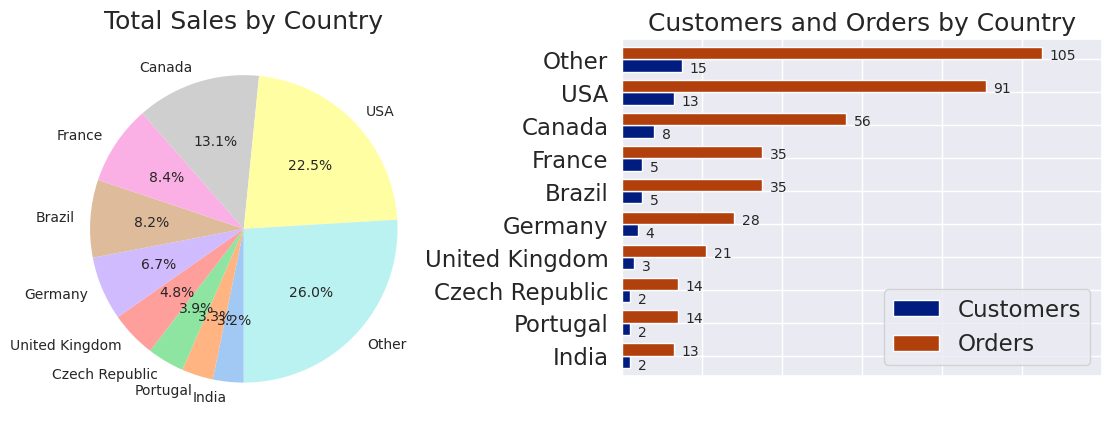

In [12]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,1.2]}, figsize=(12, 5))

with sns.color_palette("pastel"):
    ax0 = (
        df_country_stats.plot.pie(
            ax=ax[0],
            y="total_sales",
            title="Total Sales by Country",
            counterclock=False,
            startangle=-90,
            autopct="%1.1f%%",
            fontsize=10,
            wedgeprops={"linewidth": 0},
            ylabel="",
            legend=False,
        )
    )

ax1 = (
    df_country_stats.plot.barh(
        ax=ax[1],
        y=["n_customers", "n_orders"],
        title="Customers and Orders by Country",
        xlim=(0, 120),
        ylabel="",
        width=0.75,
        legend=True,
    )
)
for i, v in enumerate(df_country_stats["n_customers"]):
    ax1.annotate(f"{v}", (v + 2, i - .4), fontsize=10)
for i, v in enumerate(df_country_stats["n_orders"]):
    ax1.annotate(f"{v}", (v + 2, i), fontsize=10)
ax1.set_xticklabels([])
ax1.legend(["Customers", "Orders"], loc="lower right")
ax1.set_position([.6, .2, .4, .675])

### Employee sales performance

In [13]:
%%sql

with

employee_sales as (

    select 

        c.SupportRepId as EmployeeId,
        sum(i.Total) as total_sales

    from Invoice i
        join Customer c using(CustomerId)
    
    group by 1

)

select

    e.FirstName || " " || e.LastName as employee_name,
    es.total_sales

from Employee e
    left join employee_sales es using(EmployeeId)

order by total_sales desc

,employee_name,total_sales
0,Jane Peacock,833.04
1,Margaret Park,775.40
2,Steve Johnson,720.16
3,Andrew Adams,NaN
4,Nancy Edwards,NaN
5,Michael Mitchell,NaN
6,Robert King,NaN
7,Laura Callahan,NaN


### Bestselling music genre in the US market

In [14]:
%%sql df_us_market <<

with

usa_tracks_sold as (

    select il.*

    from InvoiceLine il
        join Invoice i using(InvoiceId)
        join Customer c using(CustomerId)
        
    where c.Country = "USA"
    
),

aggregated_by_genre as (

    select

        g.Name genre,
        count(uts.InvoiceLineId) tracks_sold,
        round(
            cast(count(uts.InvoiceLineId) as float) / (select count(1) from usa_tracks_sold),
            2
         ) share_sold

    from usa_tracks_sold uts
        join Track t using(TrackId)
        join Genre g using(GenreId)

    group by 1
    order by 2 desc

)

select * from aggregated_by_genre limit 5

In [15]:
df_us_market  # Display the last query result

,genre,tracks_sold,share_sold
0,Rock,157,0.32
1,Latin,91,0.18
2,Metal,64,0.13
3,Alternative & Punk,50,0.10
4,Jazz,22,0.04


#### Plot results

In [16]:
df_us_market = df_us_market.set_index("genre", drop=True).sort_values("share_sold", ascending=True)

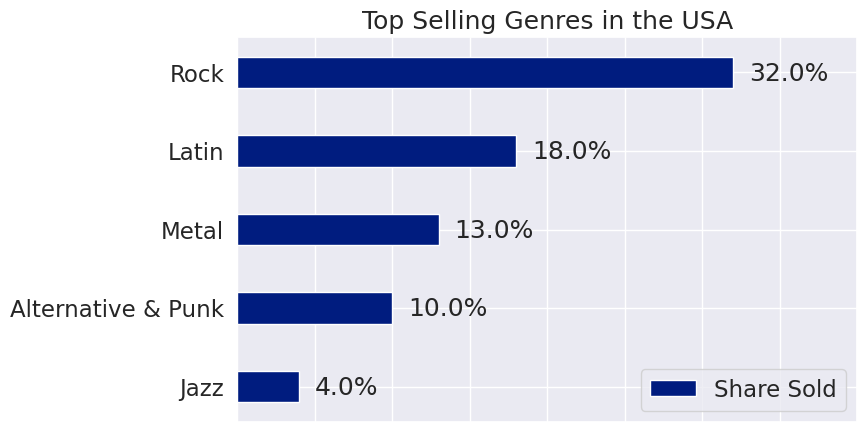

In [17]:
ax = (
    df_us_market.plot.barh(
        y="share_sold",
        title="Top Selling Genres in the USA",
        ylabel="",
        width=0.4,
        figsize=(8, 5),
        xlim=(0, 0.4),
    )
)
for i, v in enumerate(df_us_market["share_sold"]):
    ax.annotate(f"{v * 100}%", (v + .01, i - .1))
ax.set_xticklabels([])
ax.legend(["Share Sold"], loc="lower right");